In [1]:
import numpy as np
import matplotlib.pyplot as plt
import enzyme_utils_hpw as utils
import pymc3 as pm
import theano.tensor as tt
from scipy import stats

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import logging
logger = logging.getLogger('pymc3')
logger.setLevel(logging.ERROR)

# Box Loop - Modelling

### Dataset

First, lets take a look at the buffer dataset: 

In [16]:
dir_ = 'new_data/transformed_buffer/'
x, y, t, track_info, lookup, track_id = utils.loadRawMinData(dir_, min_length=5, isDx=False)
x, y, t, dx, dy, dt, lookup, track_info = utils.removeAllOutliers(x, y, t, track_info)

Total 15 files read; Total 813 trajectories (length >= 5) loaded; Total 23909 data points


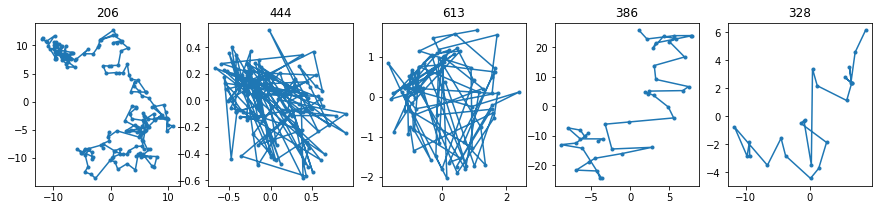

In [17]:
sel_ind = [206, 444, 613, 386, 328]
utils.manyplots_real(1, 5, sel_ind, track_info, [x, y, t])

### Simple BM model

Above figure shows tracks selected from the buffer dataset, note that each box doesn't contain the same number of pixels. The simplest model we have to analyze nanoparticle diffusion is the $\textbf{Brownian motion model}$. If we assume an inverse gamma prior for the diffusion coefficient, we can obtain the full analytical posterior (derivation for this and other models are given in seperate notebooks).

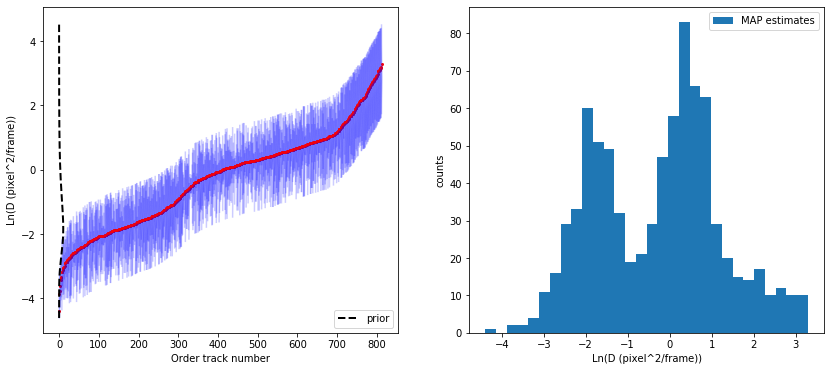

In [18]:
utils.draw_vertical_posterior_bm([dx, dy, dt], 0.25, 0.2, track_info)

Two takeaways from the above figure: 
1. we have many short trajs in the dataset (len~5), as indicated by the many uncertain posteriors shown in the left plot. 
2. The enzymes seeme to be diffusing in two distint modes, one is characterized by the left peak, and the other by the right peak as shown in the right plot.

Those slow diffuising population all have those very confined, blob like motions shown in the first figure, as a results, we came up with two hypothesis for this population based on our understandings of the expermental systems: 1. $\textbf{Stuck enzyme model}$; 2.  $\textbf{Harmonic potential well model}$

### Stuck and HPW model

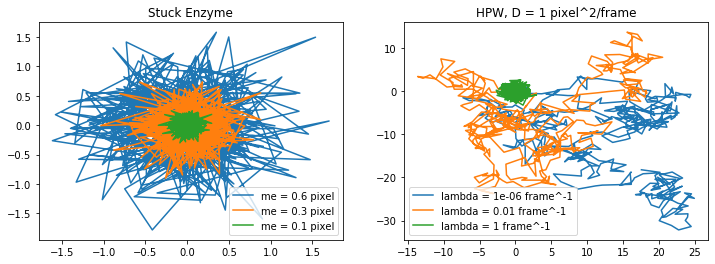

In [19]:
me = [0.6, 0.3, 0.1]
lambda_ = [1e-06, 0.01, 1]
n_times = 423
t_ = [i for i in range(n_times+1)]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for i in range(len(me)): 
    x_, y_ = utils.simulate_stuck(me[i], n_times)
    hpw = utils.base_HPW_D([0, 0], t_, 1, [0, 0], lambda_[i])
    axes[0].plot(x_, y_, label='me = ' + str(me[i]) + ' pixel')
    np.random.seed(5555) 
    axes[1].plot(hpw[0], hpw[1], label='lambda = ' + str(lambda_[i]) + ' frame^-1' , )

axes[0].set_title('Stuck Enzyme')
axes[1].set_title('HPW, D = 1 pixel^2/frame')
axes[0].legend()
axes[1].legend();

We see that both stuck enzyme and HPW model seems to be able to reproduce the confined behavior observed in the actual dataset. However, for reasons that will be discussed later, we are going to use the HPW model to analyze the dataset. One advantage is we can use the HPW model to capture the behaviors of both populations with differnt lambda values. 

### Autocorrelation analysis

For the HPW model, we have a few important paramters: D, lambda and timesteps. The dimensionless paramters from the combiations of those paramters has a huge effect on the inference of D and lambda. Generally speaking, with the framerate that we have (~ 12 frames/s), the hpw model will have a diffcult time with tracks that have very large well strength. This point is illustrated by the autocorrelation analysis on simulated data below:  

In [20]:
lam_lis = np.linspace(1, 100, 15)
t_ = np.linspace(0, 8*3, 101*3)
_, x_lis, error_lis =  utils.auto_x_dx(0.175, lam_lis,  t_, 20, 1)

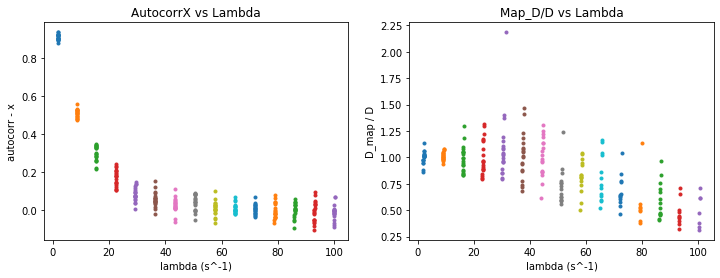

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for i in range(len(lam_lis)): 

    axes[0].plot(lam_lis[i] + x_lis[i], x_lis[i], '.')
    axes[1].plot(lam_lis[i]+ error_lis[i], error_lis[i], '.')

axes[0].set_title('AutocorrX vs Lambda')
axes[1].set_title('Map_D/D vs Lambda')
axes[0].set_xlabel('lambda (s^-1)')
axes[1].set_xlabel('lambda (s^-1)')
axes[0].set_ylabel('autocorr - x')
axes[1].set_ylabel('D_map / D');

The high level explanations behind this is that for small lambda, the track is largely diffusive, and hence each position point should be very correlated to its previous position (how brownian motion works). However, with our framerate, we see that as lambda got passed 20, the autocorrelation in position reduced effectively to 0, means that the well strength are so strong, each position is just sampled from a gaussian like distribution (this also happens for stucked enzyme!). The Map_D and true D ratio plot tells that, we have good hope to use the HPW model on the moderately confined tracks (lambda < 20 s^-1). We can still do inference on the strong confined tracks, but we should assign less weight to thsoe results.  

# Box Loop - Inference

# Box Loop - Model Criticism

### Posterior Predictive Checks

We are going to use PPC with 2 different metrics to show that why the simple BM model and the Stuck enzyme model are not suitable for the confined population (as least part of them, since as the well strength increases, HPW model is essentially the same as stuck enzyme model).

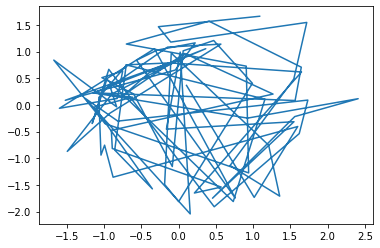

In [22]:
# track of interest
sx, sy, st = utils.loadSelectTraj(x, y, t, track_info, 613, False)
sx, sy, st = utils.removeOutLiar(sx, sy, st)
sdx, sdy, sdt = sx[1:]-sx[:-1], sy[1:]-sy[:-1], st[1:]-st[:-1]
plt.plot(sx, sy);

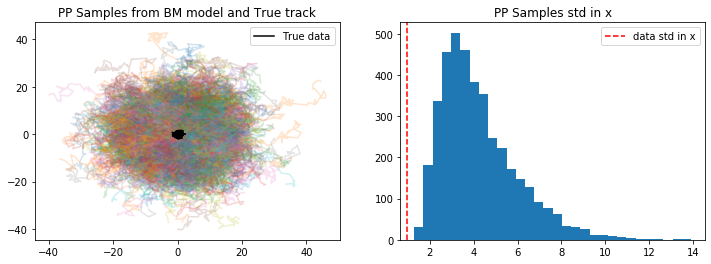

In [24]:
utils.PPCs([sx, sy, st, sdx, sdy, sdt], 'bm')

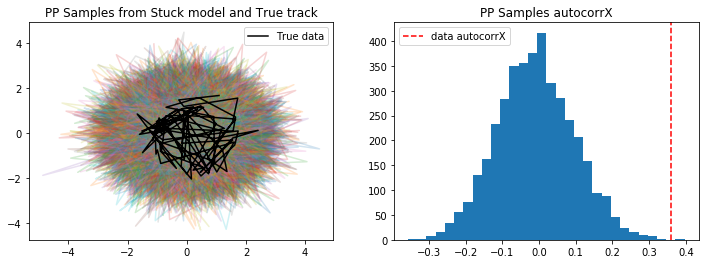

In [25]:
utils.PPCs([sx, sy, st, sdx, sdy, sdt], 'me')

For the bm model, we see that although it is able to infer the diffusion coefficient, the posterior samples don not at all resemble the true track. For the Stuck model, although the PP samples looks like the true track, the PPCs tells us that this model is not very likelihood for this specific track.